In [1]:
import kagglehub

path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

# print("Path to dataset files:", path)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

In [3]:
file_name = [file for file in os.listdir(path) if file.endswith('.csv')][0]
file_path = os.path.join(path, file_name)
data = pd.read_csv(file_path)

In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
data.shape

(918, 12)

In [6]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ChestPainType'] = data['ChestPainType'].map({'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3})
data['RestingECG'] = data['RestingECG'].map({'Normal': 0, 'ST': 1, 'LVH': 2})
data['ST_Slope'] = data['ST_Slope'].map({'Up': 0, 'Flat': 1, 'Down': 2})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'N': 0, 'Y': 1})
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,0,140,289,0,0,172,0,0.0,0,0
1,49,0,1,160,180,0,0,156,0,1.0,1,1
2,37,1,0,130,283,0,1,98,0,0.0,0,0
3,48,0,2,138,214,0,0,108,1,1.5,1,1
4,54,1,1,150,195,0,0,122,0,0.0,0,0


In [8]:
data = data.drop(columns=["ChestPainType", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"])
data = data.rename(columns={"Sex": "C_Sex", "HeartDisease": "C_HeartDisease"}) # C stands for context only, not meant to be analyzed
selected_columns = ["Age", "RestingBP", "Cholesterol"]
data.head()

,Age,C_Sex,RestingBP,Cholesterol,C_HeartDisease
0,40,1,140,289,0
1,49,0,160,180,1
2,37,1,130,283,0
3,48,0,138,214,1
4,54,1,150,195,0


In [9]:
data = data[data['Cholesterol'] != 0]

In [10]:
data.describe()

,Age,C_Sex,RestingBP,Cholesterol,C_HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,0.756032,133.022788,244.635389,0.477212
std,9.505888,0.429762,17.282750,59.153524,0.499816
min,28.000000,0.000000,92.000000,85.000000,0.000000
25%,46.000000,1.000000,120.000000,207.250000,0.000000
50%,54.000000,1.000000,130.000000,237.000000,0.000000
75%,59.000000,1.000000,140.000000,275.000000,1.000000
max,77.000000,1.000000,200.000000,603.000000,1.000000


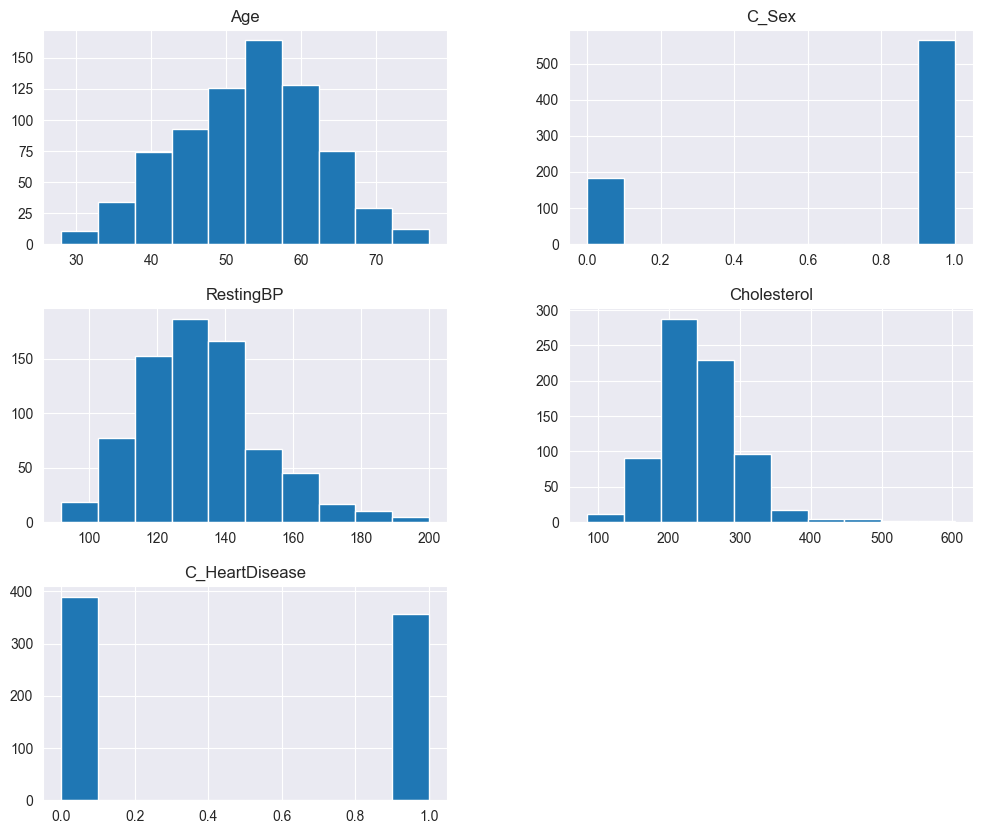

In [11]:
data.hist(figsize=(12, 10))
plt.show()

In [12]:
def remove_outliers_iqr(df, selected_columns):
    print("Hello from IQR method function.")
    for column in selected_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [13]:
def remove_outliers_std(df, selected_columns, threshold=3):
    print("Hello from STD method function.")
    for column in selected_columns:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [14]:
def plot_outliers(df, selected_columns, outlier_mask, title="Outliers Detection"):
    num_columns = len(selected_columns)

    if num_columns == 1:
        col = selected_columns[0]
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x=range(len(df)),
            y=df[col],
            hue=outlier_mask,
            palette={False: 'blue', True: 'red'},
            style=outlier_mask,
            markers={False: 'o', True: 'X'},
            s=100
        )
        plt.title(title)
        plt.xlabel("Index")
        plt.ylabel(col)
        plt.legend(title="Outlier")
        plt.show()

    elif num_columns == 2:
        x_col, y_col = selected_columns
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x=df[x_col],
            y=df[y_col],
            hue=outlier_mask,
            palette={False: 'blue', True: 'red'},
            style=outlier_mask,
            markers={False: 'o', True: 'X'},
            s=100
        )
        plt.title(title)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.legend(title="Outlier")
        plt.show()

    elif num_columns == 3:
        x_col, y_col, z_col = selected_columns
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            df[x_col], df[y_col], df[z_col],
            c=outlier_mask, cmap='coolwarm', marker='o', s=60
        )
        ax.set_title(title)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        plt.colorbar(scatter, label="Outlier (1 = True, 0 = False)")
        plt.show()
    else:
        print("Można wizualizować tylko 1, 2 lub 3 kolumny.")

In [15]:
def remove_outliers_knn(df, selected_columns, k_percent):
    k = max(1, int(len(df) * (k_percent / 100)))
    nbrs = NearestNeighbors(n_neighbors=k + 1)
    data_points = df[selected_columns].values

    nbrs.fit(data_points)
    distances, _ = nbrs.kneighbors(data_points)
    kth_distances = distances[:, -1]
    threshold = np.percentile(kth_distances, 100 - k_percent)

    outlier_mask = kth_distances > threshold

    plot_outliers(df, selected_columns, outlier_mask, title=f"Outliers Detection (k={k_percent}%)")

    return df[~outlier_mask]

# Funkcja traktuje dane jako punkty w przestrzeni wielowymiarowej, gdzie każda kolumna jest jednym z wymiarów. Wartości odstające są identyfikowane na podstawie odległości w tej przestrzeni, a nie osobno dla każdej kolumny.

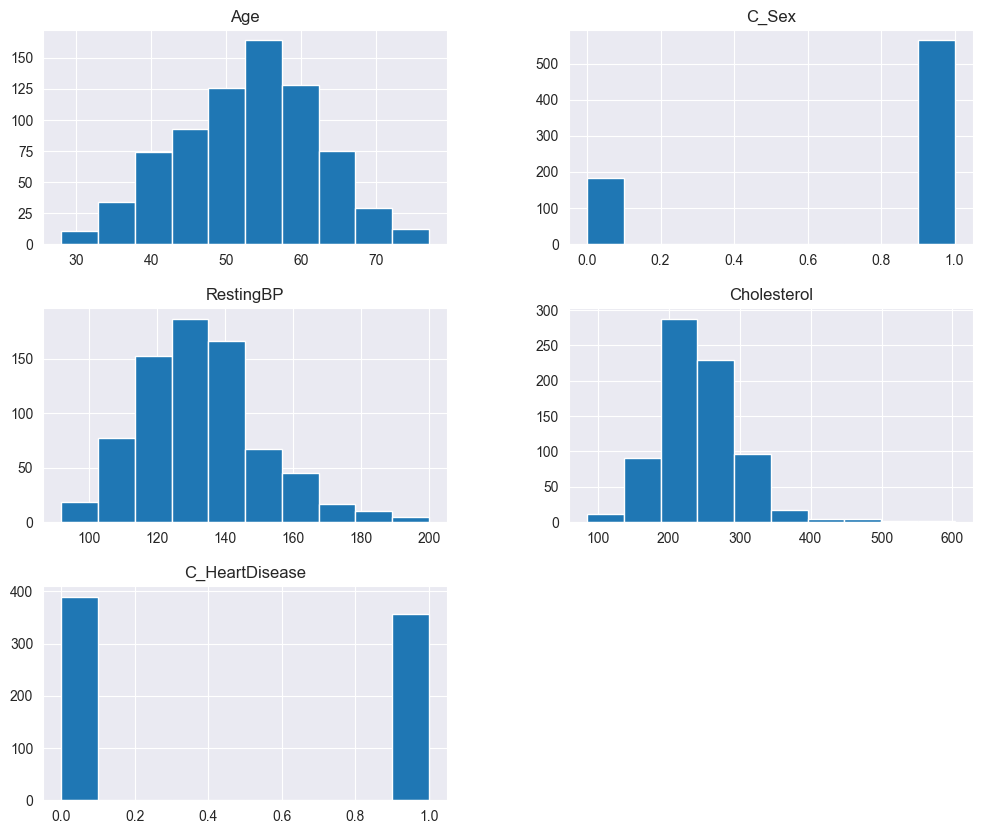

In [16]:
data.hist(figsize=(12, 10))
plt.show()

Data size before: (746, 5)


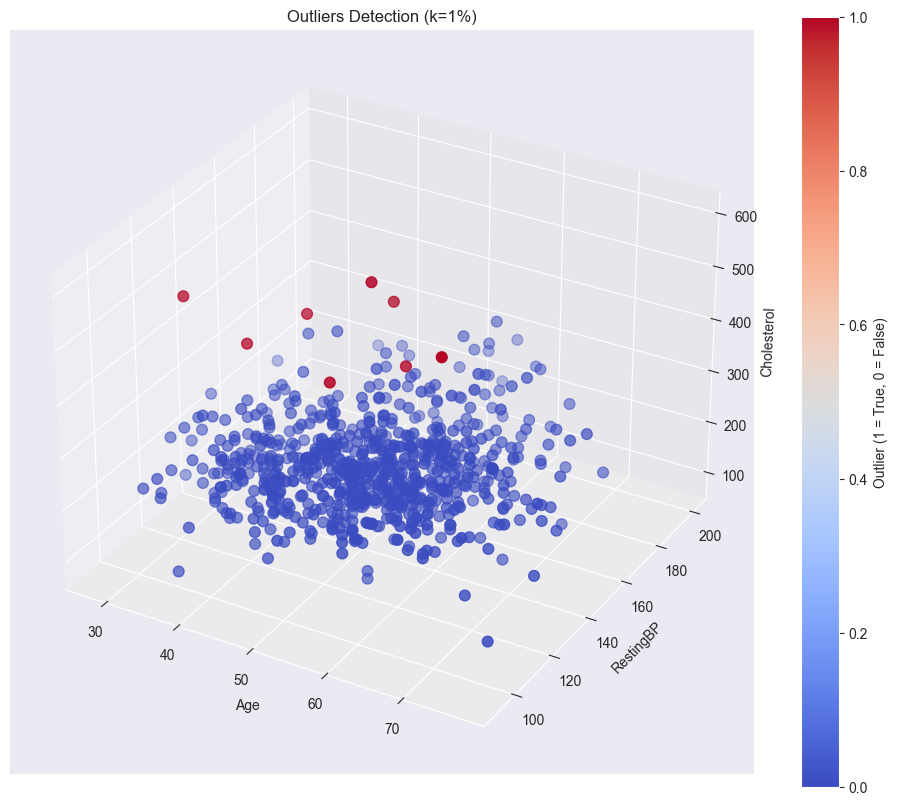

Data size after: (738, 5)


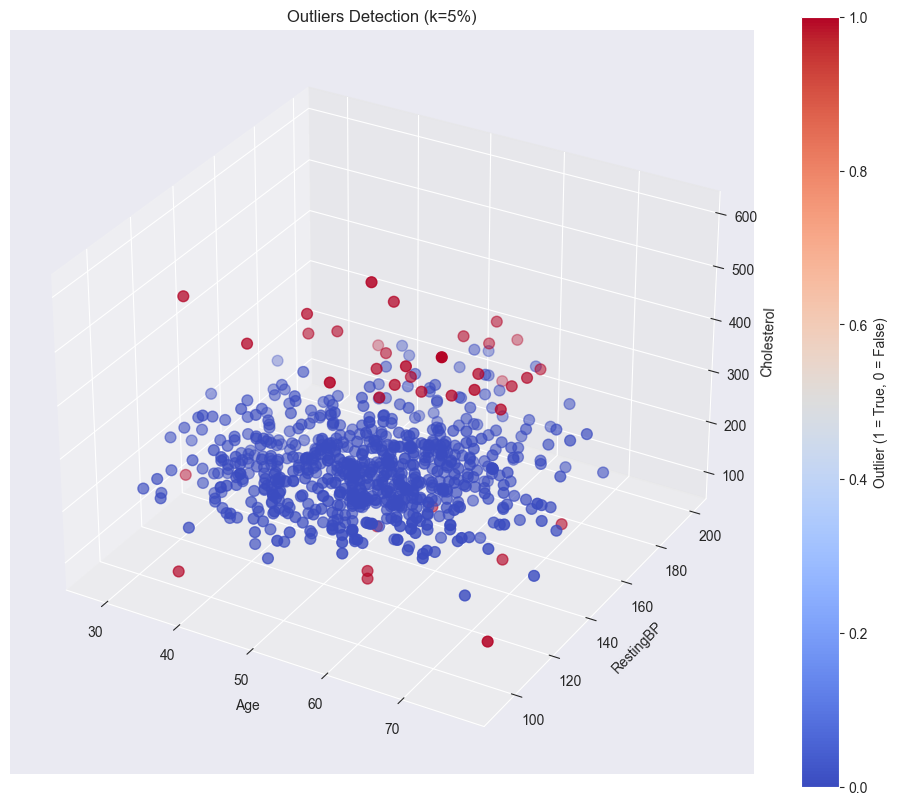

Data size after: (708, 5)


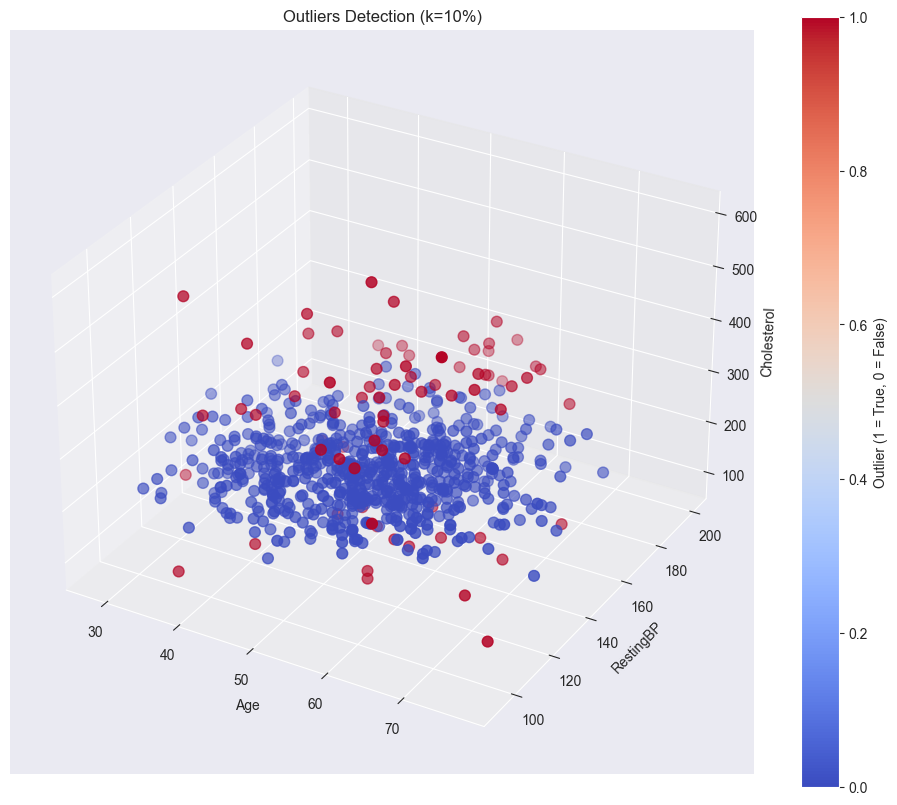

Data size after: (671, 5)


In [17]:
print(f"Data size before: {data.shape}")
k = [1, 5, 10] # percent
for percent in k:
  data_after = remove_outliers_knn(data, selected_columns, percent)

  print(f"Data size after: {data_after.shape}")

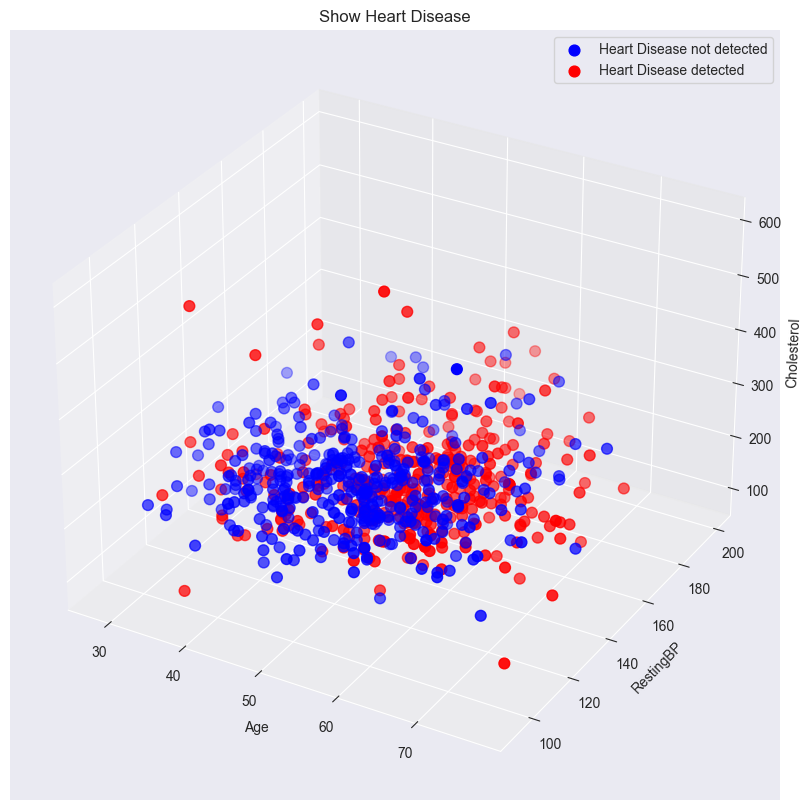

In [18]:
def plot_heart_disease(df, selected_columns, title="Show Heart Disease"):
    num_columns = len(selected_columns)

    x_col, y_col, z_col = selected_columns
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        df[df['C_HeartDisease'] == 0][x_col],
        df[df['C_HeartDisease'] == 0][y_col],
        df[df['C_HeartDisease'] == 0][z_col],
        color='blue', label='Heart Disease not detected', marker='o', s=60
    )

    ax.scatter(
        df[df['C_HeartDisease'] == 1][x_col],
        df[df['C_HeartDisease'] == 1][y_col],
        df[df['C_HeartDisease'] == 1][z_col],
        color='red', label='Heart Disease detected', marker='o', s=60
    )

    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)

    ax.legend()

    plt.show()


plot_heart_disease(data, selected_columns)

In [19]:
def remove_outliers_knn_2(df, selected_columns, k_percent):
    k = max(1, int(len(df) * (k_percent / 100)))
    nbrs = NearestNeighbors(n_neighbors=k + 1)
    data_points = df[selected_columns].values

    nbrs.fit(data_points)
    distances, _ = nbrs.kneighbors(data_points)
    kth_distances = distances[:, -1]
    threshold = np.percentile(kth_distances, 100 - k_percent)

    outlier_mask = kth_distances > threshold
    data_removed = df[outlier_mask]

    return data_removed


k = [1, 5, 10] # percent
for percent in k:
    data_removed = remove_outliers_knn_2(data, selected_columns, percent)

    ill_count = (data_removed['C_HeartDisease'] == 1).sum()
    healthy_count = (data_removed['C_HeartDisease'] == 0).sum()

    print(f"Percentage: {percent}%")
    print(f"Number of removed data (HeartDisease = 1): {ill_count}")
    print(f"Number of removed data (HeartDisease = 0): {healthy_count}")
    print("-" * 50)


Percentage: 1%
Number of removed data (HeartDisease = 1): 5
Number of removed data (HeartDisease = 0): 3
--------------------------------------------------
Percentage: 5%
Number of removed data (HeartDisease = 1): 21
Number of removed data (HeartDisease = 0): 17
--------------------------------------------------
Percentage: 10%
Number of removed data (HeartDisease = 1): 43
Number of removed data (HeartDisease = 0): 32
--------------------------------------------------


In [20]:
scaler = MinMaxScaler()  # StandardScaler()
data[selected_columns] = scaler.fit_transform(data[selected_columns])

In [21]:
data.head()

,Age,C_Sex,RestingBP,Cholesterol,C_HeartDisease
0,0.244898,1,0.444444,0.393822,0
1,0.428571,0,0.629630,0.183398,1
2,0.183673,1,0.351852,0.382239,0
3,0.408163,0,0.425926,0.249035,1
4,0.530612,1,0.537037,0.212355,0


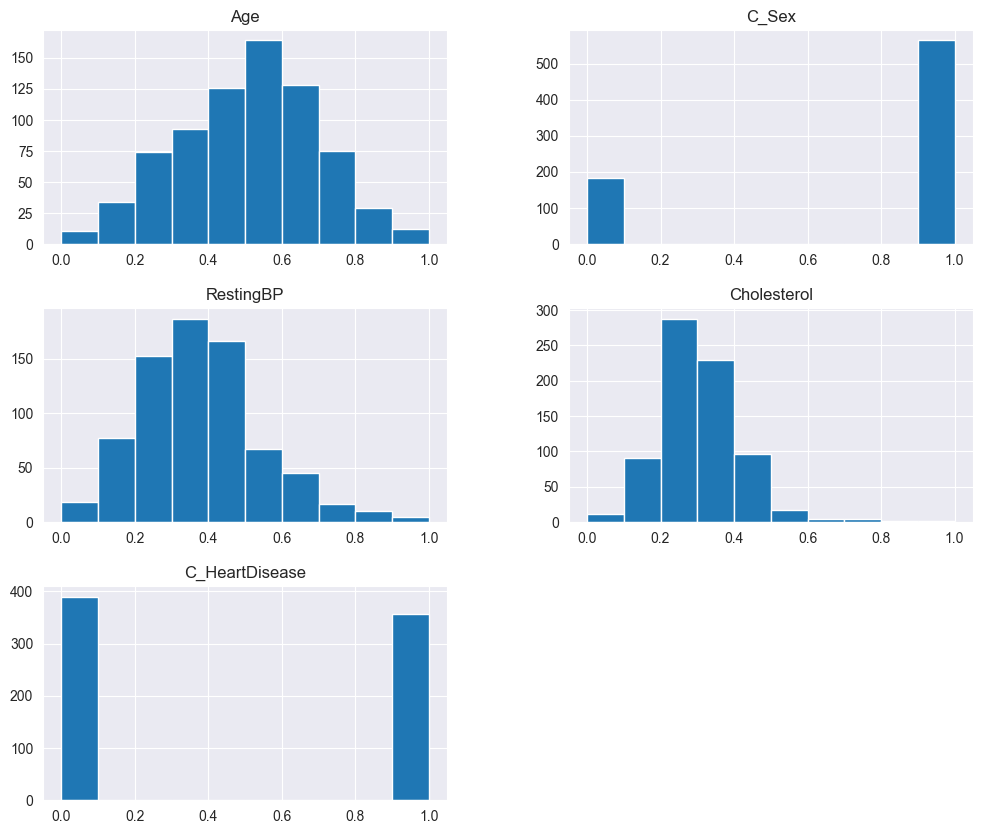

In [22]:
data.hist(figsize=(12, 10))
plt.show()

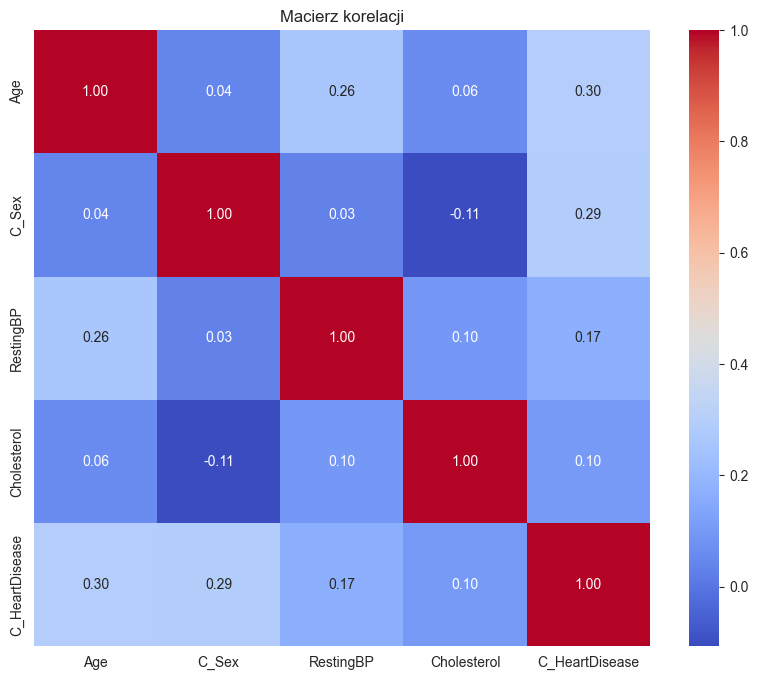

In [23]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Macierz korelacji")
plt.show()

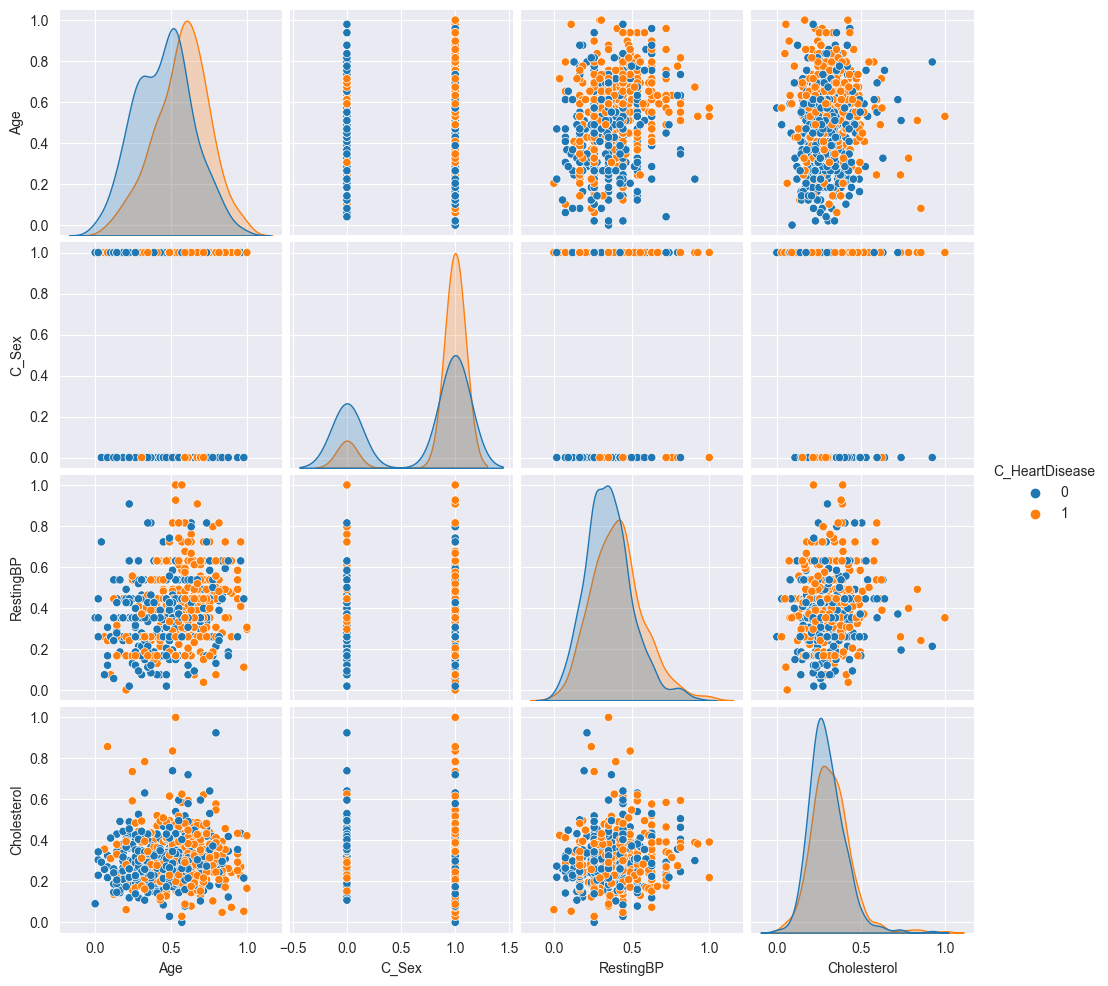

In [24]:
sns.pairplot(data, hue='C_HeartDisease')
plt.show()

In [25]:
warnings.filterwarnings("ignore", category=FutureWarning)

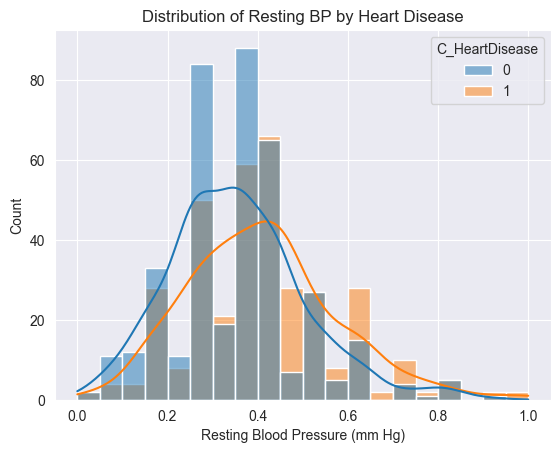

In [26]:
sns.histplot(x='RestingBP', hue='C_HeartDisease', data=data, kde=True, bins=20)
plt.title('Distribution of Resting BP by Heart Disease')
plt.xlabel('Resting Blood Pressure (mm Hg)')
plt.show()

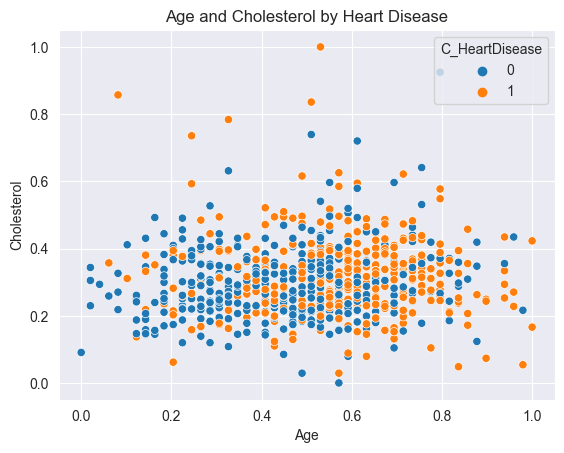

In [27]:
sns.scatterplot(x='Age', y='Cholesterol', hue='C_HeartDisease', data=data)
plt.title('Age and Cholesterol by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.show()

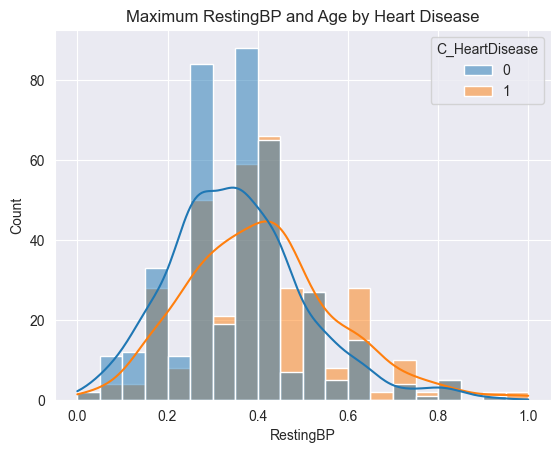

In [28]:
sns.histplot(x='RestingBP', hue='C_HeartDisease', data=data, kde=True, bins=20)
plt.title('Maximum RestingBP and Age by Heart Disease')
plt.show()

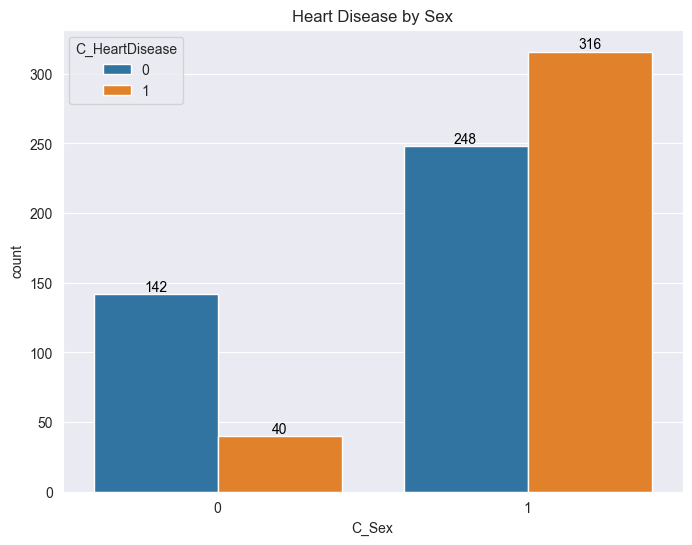

In [29]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='C_Sex', hue='C_HeartDisease', data=data)
plt.title('Heart Disease by Sex')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

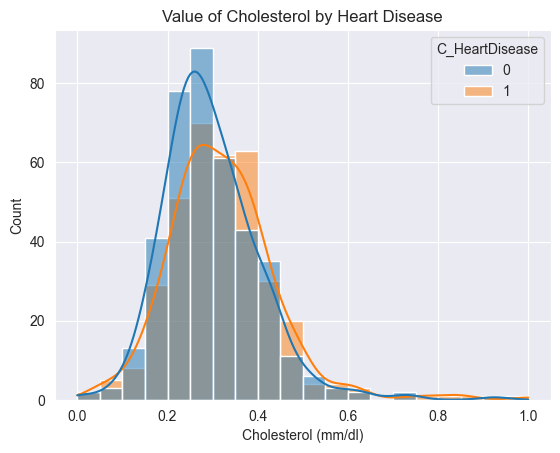

In [30]:
sns.histplot(x='Cholesterol', hue='C_HeartDisease', data=data, kde=True, bins=20)
plt.title('Value of Cholesterol by Heart Disease')
plt.xlabel('Cholesterol (mm/dl)')
plt.show()
# Wartości 0 cholesterolu bo nie zmierzone.

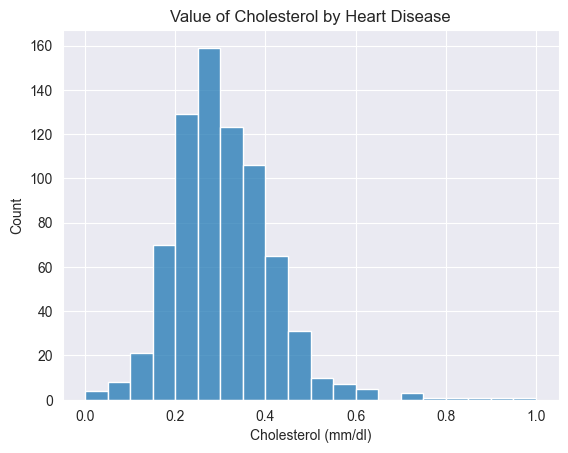

In [31]:
sns.histplot(x='Cholesterol', data=data, bins=20)
plt.title('Value of Cholesterol by Heart Disease')
plt.xlabel('Cholesterol (mm/dl)')
plt.show()
# Prawidlowe wartosci do okolo 200
# Wysoki poziom od okolo 250

Centroids of clusters:
[[0.29036735 0.31203704 0.29559073]
 [0.59144427 0.31775285 0.30535343]
 [0.66137977 0.57724436 0.33006337]]


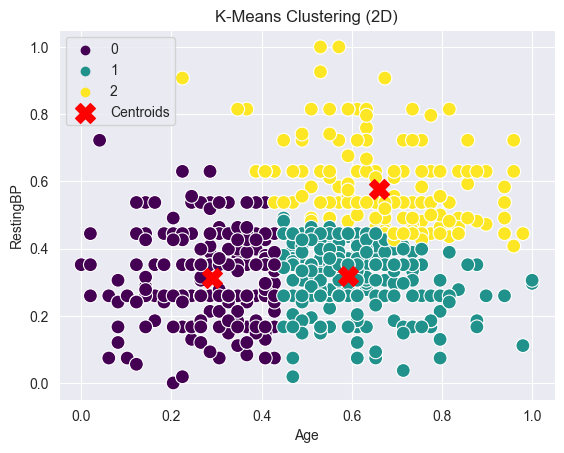

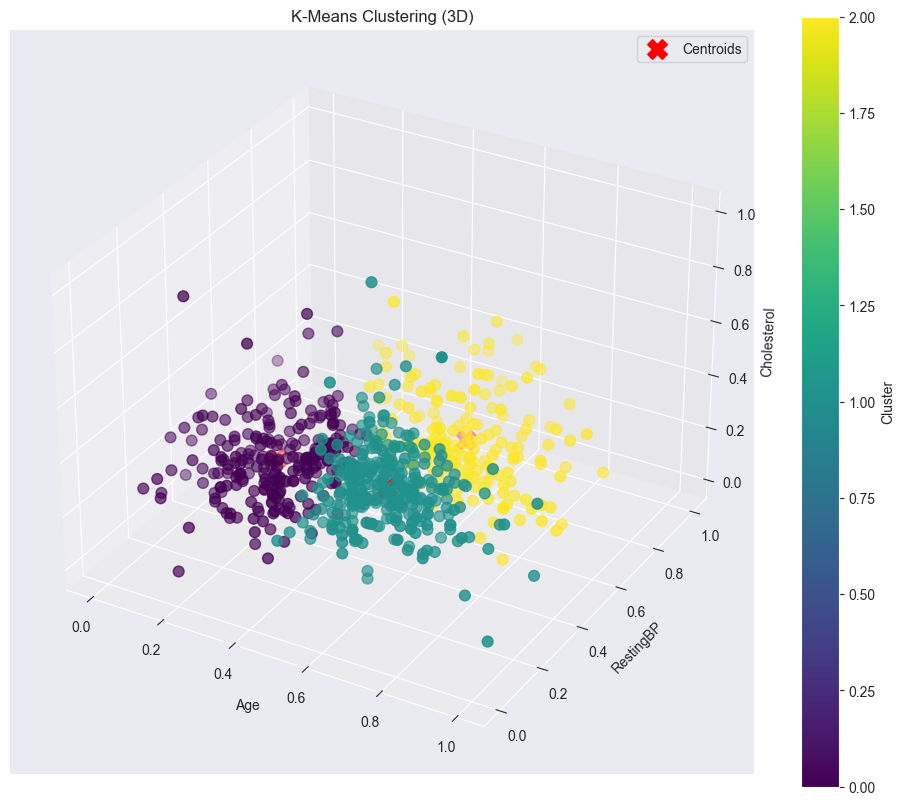

In [32]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[selected_columns])

print("Centroids of clusters:")
print(kmeans.cluster_centers_)

sns.scatterplot(x=data[selected_columns[0]], y=data[selected_columns[1]], hue=data['Cluster'], palette='viridis', s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering (2D)')
plt.xlabel(selected_columns[0])
plt.ylabel(selected_columns[1])
plt.legend()
plt.show()

if len(selected_columns) == 3:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        data[selected_columns[0]], data[selected_columns[1]], data[selected_columns[2]],
        c=data['Cluster'], cmap='viridis', s=60
    )
    ax.scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
        color='red', marker='X', s=200, label='Centroids'
    )

    ax.set_title('K-Means Clustering (3D)')
    ax.set_xlabel(selected_columns[0])
    ax.set_ylabel(selected_columns[1])
    ax.set_zlabel(selected_columns[2])
    ax.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()
